# Hierarchical model
Hello, today we will try to recreate the hierarchical model as described in *Bishop & Tipping (1998)* in PyStan! In the original model, an *interactive* workflow is presented in which the user determines the number of clusters of latent data and locates their locations for the algorithm. To mimic this approach, we execute the steps of the algorithm individually, while passing the number of clusters and their approximate locations (through a $k$-means clustering algorithm) to the next step.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
from utils import loadStan
from sklearn.metrics import adjusted_rand_score
sns.set()

In [171]:
ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas', recompile=True)
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4dc7996805fa08668353198f9d66bacf NOW.


Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model compiled succesfully.
Model saved succesfully to cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.


## Generating data
Data was generated according to the description in Bishop & Tippings paper.

In [112]:
def cols(inds = ind, alpha=np.ones((N))):
    colrs = np.zeros((N,4))
    for k in range(K):
        colrs[inds==k, k] = 1.0
    colrs[:,1] = colrs[:,1]/1.5
    colrs[:,3] = alpha
    return colrs

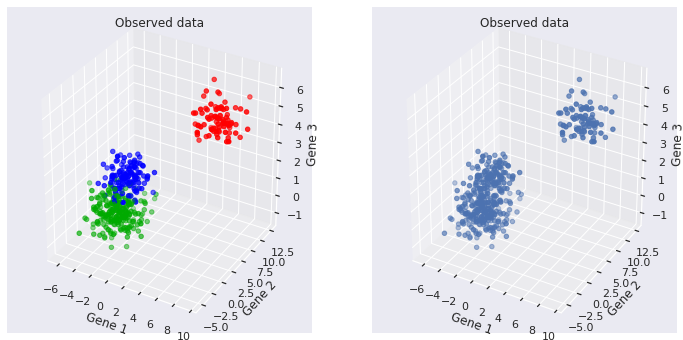

In [73]:
N=450
M=2
D=3
K=3

sig = 3

mu = np.random.normal(0,1.6,size=(K,D))
mu[0]+=np.random.uniform(2*sig,3*sig, size=D)

sigma = [np.random.uniform(sig/2,sig,size=(D)) for k in range(K)]
for k in range(K):
    flat_dim = np.random.randint(D)
    sigma[k][k]=sigma[k][flat_dim]/5
cov = [np.diag(sigma[k]) for k in range(K)]

while True:      # make sure to not have a negligible cluster
    theta = np.random.dirichlet(np.ones(K))
    if np.all(theta>(1.0/(2*K))):
        break
        
ind = np.ones(N)
x = np.zeros((N,D))

for n in range(N):
    opt = np.random.choice(list(range(K)), p=theta)
    ind[n] = opt
    newentry = np.random.multivariate_normal(mu[opt], cov[k])
    x[n,:] = newentry

ind_col = np.zeros((N,3))
for k in range(K):
    ind_col[ind==k, k] = 1.0
ind_col[:,1] = ind_col[:,1]/1.5
    
sns.set()
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=cols())
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2])
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

## First level: PPCA

In [74]:
ppca_dat = {'N':N, 'M':M, 'D':D, 'x':x}
fit = ppca_model.sampling(data=ppca_dat, iter=200, chains=1)
fitreturn = fit.extract()

best_ind = np.where(fitreturn['lp__']==max(fitreturn['lp__']))[0][0]

In [75]:
W_sim_ppca1 = np.mean(fitreturn['W'], axis=0)
sigma_sim_ppca1 = np.mean(fitreturn['sigma'], axis=0)
mu_sim_ppca1 = np.mean(fitreturn['mu'], axis=0)
latent_sim_ppca1 = fitreturn['z'][best_ind]

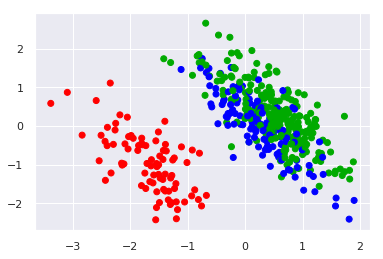

In [76]:
plt.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:], c = cols())
plt.show()

## Second level: Mixture model on the latent space

### Selecting the separate clusters in the latent space

We use the 2 dimensional PPCA plot to select what looks like two clusters, and then pass the selected points to a mixture model in the full, original space. The article of Bishop and Tipping selects the clusters manually, we use a $k$-means clustering algorithm to select the clusters in the latent space and then pass these clusters to the original space.

In [77]:
K_inter = 2
kmeans_init = KMeans(K_inter).fit(latent_sim_ppca1.T)

gmm_dat = {'N': N,'K': K_inter, 'D':M, 'y':latent_sim_ppca1.T}
fit = gmm_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':kmeans_init.cluster_centers_}])
fit_ext2 = fit.extract()
best_ind2 = np.where(fit_ext2['lp__']==max(fit_ext2['lp__']))[0][0]

In [78]:
clus_lat_gmm1 = np.mean(fit_ext2['z'],axis=0)
theta_sim_gmm1 = np.mean(fit_ext2['theta'],axis=0)
mu_sim_gmm1 = np.mean(fit_ext2['mu'],axis=0)
sigmas_sim_gmm1 = np.mean(fit_ext2['sigma'],axis=0)
clus_lat_norm_gmm1 = (np.exp(clus_lat_gmm1).T/sum(np.exp(clus_lat_gmm1).T))
clus_selec1 = np.argmax(clus_lat_norm_gmm1, axis=0)

In [79]:
if sum(clus_selec1==0)>sum(clus_selec1==1):
    clus_selec1 = 1-clus_selec1
    clus_lat_norm_gmm1[[0,1]] = clus_lat_norm_gmm1[[1,0]]

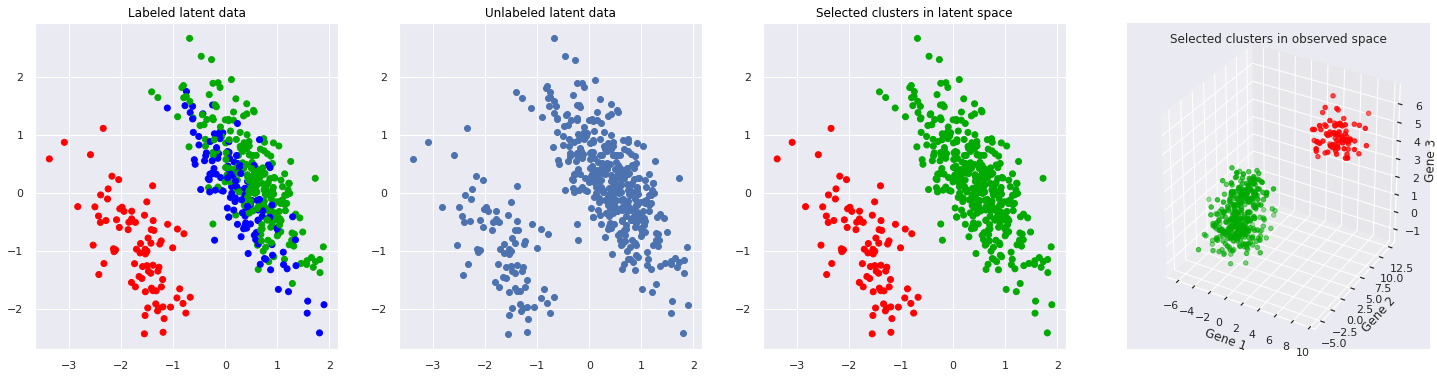

In [114]:
fig = plt.figure(figsize=(25,6))
ax=fig.add_subplot(1,4,1)
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:], c = cols())
title = ax.set_title("Labeled latent data")
plt.setp(title, color='black') 
ax=fig.add_subplot(1,4,2)
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:])
title = ax.set_title("Unlabeled latent data")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,4,3)
ax.scatter(latent_sim_ppca1.T[:,0],latent_sim_ppca1.T[:,1], c=cols(inds=clus_selec1))
title = ax.set_title("Selected clusters in latent space")
plt.setp(title, color='black')
ax = fig.add_subplot(144, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=cols(clus_selec1))
ax.set_title('Selected clusters in observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

### Initializing the latent variable mixture model based on selected clusters

In [161]:
cc3d = [np.average(x,axis=0, weights=clus_lat_norm_gmm1[k,:]) for k in range(K_inter)]

In [ ]:
gmm_dat = {'N': N,'M':M,'K': K_inter, 'D':D, 'y':x}
fit = moppcas_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':cc3d}])
fit_ext_molv1 = fit.extract()
best_ind_molv1 = np.where(fit_ext_molv1['lp__']==max(fit_ext_molv1['lp__']))[0][0]

In [148]:
latent_molv1 = fit_ext_molv1['z'][best_ind_molv1]
clus_molv1 = np.mean(fit_ext_molv1['clusters'],axis=0)
theta_molv1 = np.mean(fit_ext_molv1['theta'],axis=0)
mu_sim_molv1 = np.mean(fit_ext_molv1['mu'],axis=0)
sigmas_sim_molv1 = np.mean(fit_ext_molv1['sigma'],axis=0)
clus_norm_molv1 = (np.exp(clus_molv1).T/sum(np.exp(clus_molv1).T))

cats_full1 = np.argmax(clus_norm_molv1,axis=0)

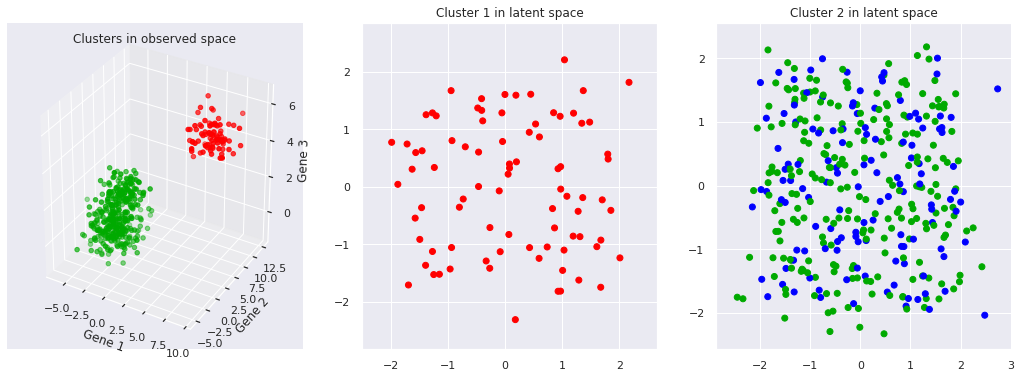

In [149]:
sns.set()
fig = plt.figure(figsize=((1+K_inter)*6,6))
ax=fig.add_subplot(1,1+K_inter,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=cols(cats_full1))
ax.set_title('Clusters in observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
for k in range(K_inter):
    ax=fig.add_subplot(1,1+K_inter,k+2)
    ax.scatter(latent_molv1[k].T[:,0],latent_molv1[k].T[:,1], c=cols(alpha=clus_norm_molv1[k,:]))
    ax.set_title('Cluster '+str(k+1)+' in latent space')
plt.show()

In [167]:
for i in np.mean(fit_ext_molv1['W'],axis=0):
    print(np.matmul(i,i.T))
    print()

[[ 0.60995477  0.12831703 -0.62709449]
 [ 0.12831703  0.68085458  0.04470048]
 [-0.62709449  0.04470048  0.69242597]]

[[0.01781566 0.01051234 0.0075058 ]
 [0.01051234 0.00740083 0.00279804]
 [0.0075058  0.00279804 0.00538251]]



In [169]:
for k in range(K_inter):
    ppca_dat = {'N':N, 'M':M, 'D':D, 'x':x, 'weights':clus_lat_norm_gmm1[k,:]}
    fit = ppca_weighted.sampling(data=ppca_dat, iter=200, chains=1)
    fitreturntest = fit.extract()
    print(np.matmul(np.mean(fitreturntest['W'],axis=0),np.mean(fitreturntest['W'],axis=0).T))

[[3.56115325e-02 1.78790432e-02 8.36019643e-06]
 [1.78790432e-02 2.09632020e-02 6.04734149e-04]
 [8.36019643e-06 6.04734149e-04 3.00885380e-05]]
[[0.11528341 0.02784146 0.05161559]
 [0.02784146 0.30989773 0.04426375]
 [0.05161559 0.04426375 0.0264449 ]]


### Evaluation on the first separation
We use the adjusted Rand Index (ARI) to evaluate how we are doing so far! (ARI of 1.0 is perfect, ARI of 0.0 is expected on random decissions, negative ARI is worse than random.)

In [87]:
super_ind = ind.copy()
super_ind[super_ind==2] = 1

In [88]:
adjusted_rand_score(super_ind, cats_full1)

1.0

Perfect score! Since we know the labels, we can also easily compute a weighted accuracy score.

In [89]:
def weighted_Accuracy(true, weights):
    
    total = 0
    correct = 0
    for i in range(len(true)):
        total+=1
        correct+=weights[i,int(true[i])]
        
    return correct/total

In [90]:
weighted_Accuracy(super_ind, clus_norm_molv1.T)

0.9999100487127435

Again, beautiful!

## Third level: Finding clusters in the individual latent spaces
Cluster 1 does not show an underlying structure (and it really doesn't exist out of different components) , so we'll leave it alone for now. We do see vague hints of underlying sub-clusters in cluster 2, so we'll try to extract those!

### Selecting sub-clusters in the latent space

In [91]:
clus = 1    # selection of cluster to further analyze, is now always cluster 1
latent_big_clus = latent_molv1[clus]

In [92]:
K_last = 2
kmeans_init = KMeans(K_last).fit(latent_big_clus[:,clus_norm_molv1[clus,:]>0.01].T)

In [93]:
gmm_dat = {'N': N,'K': K_last, 'D':M, 'y':latent_big_clus.T,
           'weights':clus_norm_molv1[clus,:]}
fit = gmm_weighted.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':kmeans_init.cluster_centers_}])
fit_ext_gmm2 = fit.extract()
best_ind_gmm2 = np.where(fit_ext_gmm2['lp__']==max(fit_ext_gmm2['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [94]:
clus_gmm2 = np.mean(fit_ext_gmm2['z'],axis=0)
theta_sim_gmm2 = np.mean(fit_ext_gmm2['theta'],axis=0)
mu_sim_gmm2 = np.mean(fit_ext_gmm2['mu'],axis=0)
sigmas_sim_gmm2 = np.mean(fit_ext_gmm2['sigma'],axis=0)
clus_norm_gmm2 = (np.exp(clus_gmm2).T/sum(np.exp(clus_gmm2).T)).T
clus_selec2 = np.argmax(clus_norm_gmm2,axis=0)

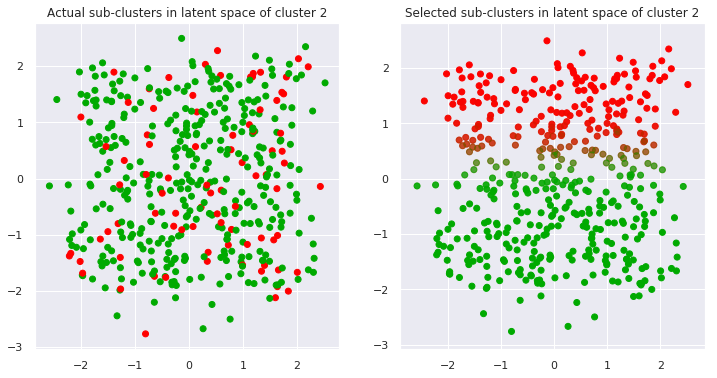

In [117]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.set_title('Actual sub-clusters in latent space of cluster 2')
ax.scatter(latent_big_clus.T[:,0], latent_big_clus.T[:,1], c=cols(super_ind), cmap='viridis')
ax = fig.add_subplot(122)
for k in range(K_last):
    ax.set_title('Selected sub-clusters in latent space of cluster 2')
    rgba_colors = np.zeros((N,4))
    rgba_colors[:,k] = 1.0
    rgba_colors[:,3] = clus_norm_gmm2[:,k]
    rgba_colors[:,1] = rgba_colors[:,1]/1.5
    ax.scatter(latent_big_clus.T[:,0], latent_big_clus.T[:,1], c=rgba_colors)
plt.show()

### Latent variable mixture model based on selected sub-clusters

In [96]:
cc3d3 = [np.average(x,axis=0, weights=clus_norm_gmm2[:,k]*clus_lat_norm_gmm1[clus,:]) for k in range(K_last)]

In [97]:
gmm_dat = {'N': N,'M':M,'K': K_last, 'D':D, 'y':x, 'weights':clus_norm_gmm2*clus_lat_norm_gmm1[clus,:][np.newaxis].T}
fit = moppcas_weighted.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':cc3d3}])
fit_ext_molv2 = fit.extract()
best_molv2 = np.where(fit_ext_molv2['lp__']==max(fit_ext_molv2['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [98]:
latent_molv2 = fit_ext_molv2['z'][best_molv2]
clus_molv2 = np.mean(fit_ext_molv2['clusters'],axis=0)
theta_sim_molv2 = np.mean(fit_ext_molv2['theta'],axis=0)
mu_sim_molv2 = np.mean(fit_ext_molv2['mu'],axis=0)
sigmas_sim_molv2 = np.mean(fit_ext_molv2['sigma'],axis=0)

In [99]:
latent_prenorm_molv2 = np.exp(clus_molv2)/np.sum(np.exp(clus_molv2),axis=1)[np.newaxis].T
latent_norm_molv2 = latent_prenorm_molv2*clus_norm_molv1[clus,:][np.newaxis].T
total_probs = np.concatenate((clus_norm_molv1[0,:][np.newaxis].T,latent_norm_molv2),axis=1)
cats_full2 = np.argmax(total_probs, axis=1)

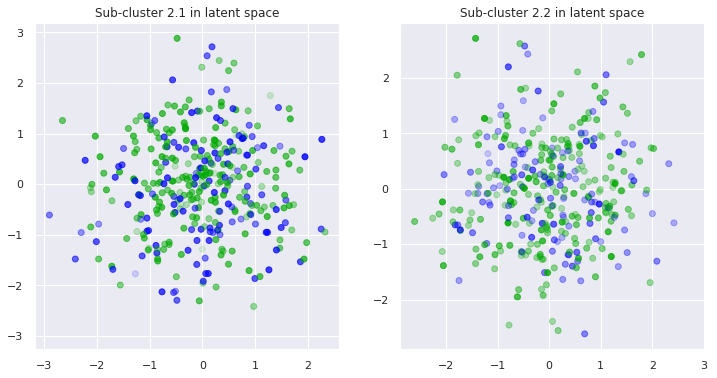

In [100]:
sns.set()
fig = plt.figure(figsize=((K_last)*6,6))
for k in range(K_last):
    ax=fig.add_subplot(1,K_last,k+1)
    ax.scatter(latent_molv2[k].T[:,0],latent_molv2[k].T[:,1], c=cols(latent_norm_molv2[:,k]), cmap='viridis')
    ax.set_title('Sub-cluster 2.'+str(k+1)+' in latent space')
plt.show()

In [101]:
print('ARI: ', adjusted_rand_score(ind[ind!=0], cats_full2[cats_full2!=0]))
print('Weighted accuracy: ', weighted_Accuracy(ind[ind!=0]-np.min(ind[ind!=0]), latent_norm_molv2[ind!=0]))

ARI:  -0.020416804132376076
Weighted accuracy:  0.49015019870347426


Not very good!

# Endresult of the hierarchical latent variable clustering model

In [102]:
all_latent = np.concatenate((latent_molv1[0][np.newaxis], latent_molv2),axis=0)

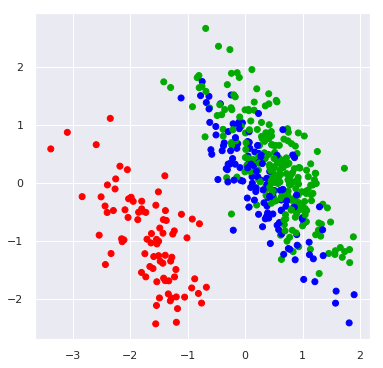

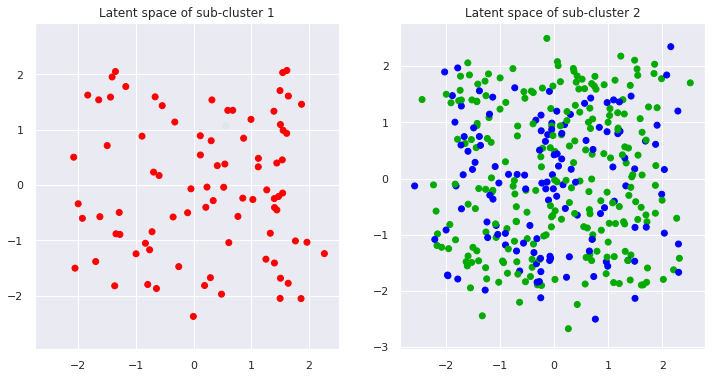

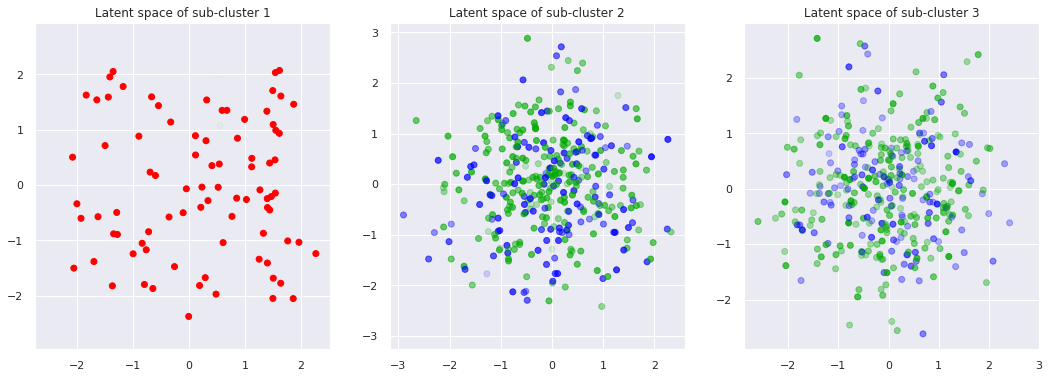

In [103]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:], c=cols())
plt.show()

fig = plt.figure(figsize=(K_inter*6, 6))
for k in range(K_inter):
    ax = fig.add_subplot(1,K_inter,k+1)
    ax.scatter(latent_molv1[k][0,:],latent_molv1[k][1,:],c=cols(clus_norm_molv1[k,:]))
    ax.set_title('Latent space of sub-cluster '+str(k+1))
plt.show()

fig = plt.figure(figsize=(K*6, 6))
for k in range(K):
    ax = fig.add_subplot(1,K,k+1)
    ax.scatter(all_latent[k][0,:],all_latent[k][1,:],c=cols(total_probs[:,k]))
    ax.set_title('Latent space of sub-cluster '+str(k+1))
plt.show()

As suggested in the original article, the density of the ink in each dot represents the posterior probability of the datapoint belonging in the sub-cluster. The colours represent the true cluster in all plots.

Text(0.5, 0, 'Gene 3')

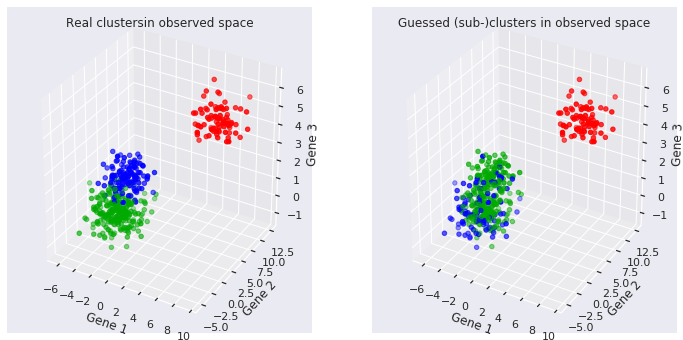

In [118]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind_col)
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Real clustersin observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax=fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=cols(cats_full2), cmap='viridis')
ax.set_title('Guessed (sub-)clusters in observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

For the evaluation:

In [31]:
adjusted_rand_score(ind, cats_full2)

0.706898476997871

In [32]:
weighted_Accuracy(ind, total_probs)

0.7115856508794508